In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from src.utils import (
    process_data_loader,
    print_metrics_in_latex,
    calculate_metrics,
    get_checkpoint_paths,
    mergekfold_results,
    save_normalized_conf_matrices,
    plot_pred_vs_true,
    get_class_dependent_predictions,
    generate_radar_plots,
)
import seaborn as sns
import matplotlib.ticker as ticker
import torch

# Specify the path to your pickle file
file_path = "evaluation_metrics/classification_metrics_list.pkl"
with open(file_path, "rb") as file:
    classification_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/regression_metrics_list.pkl"
with open(file_path, "rb") as file:
    regression_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/collect_classification_results.pkl"
with open(file_path, "rb") as file:
    collect_classification_results = pickle.load(file)

file_path = "evaluation_metrics/collect_regression_results.pkl"
with open(file_path, "rb") as file:
    collect_regression_results = pickle.load(file)

### Prepare data

In [2]:
def calculate_kfold_mean_and_std(metrics_list):
    df = pd.DataFrame(metrics_list)
    numeric_cols = df.select_dtypes(include=[float]).columns
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)
    return mean_df, std_df


# Calculate mean and std from metric using k-folds
class_mean, class_std = calculate_kfold_mean_and_std(classification_metrics_list)
reg_mean, reg_std = calculate_kfold_mean_and_std(regression_metrics_list)

In [3]:
# Prepare raw results
merged_classification = mergekfold_results(collect_classification_results)
merged_regression = mergekfold_results(collect_regression_results)

### Prepare table for paper

In [4]:
import re


def get_best_KNN(mean_df, errors_df, mod):
    # Define a function to remove the KNN part
    def remove_knn(model_name):
        return re.sub(r"\+KNN\d+", "", model_name)

    # Create the Base_Model column by removing the KNN part
    mean_df["Base_Model"] = mean_df["Model"].apply(remove_knn)
    errors_df["Base_Model"] = errors_df["Model"].apply(remove_knn)

    # Group by the base model name and find the row with the maximum 'mac-f1' for each group
    if mod == "class":
        filtered_mean_df = mean_df.loc[
            mean_df.groupby(["Base_Model", "Combination"])["mac-f1"].idxmax()
        ]
    else:
        filtered_mean_df = mean_df.loc[
            mean_df.groupby(["Base_Model", "Combination"])["R2"].idxmax()
        ]

    # Drop the same indices from the errors DataFrame
    filtered_errors_df = errors_df.loc[filtered_mean_df.index]

    # Drop the Base_Model column as it's no longer needed
    filtered_mean_df = filtered_mean_df.drop(columns=["Base_Model"])
    filtered_errors_df = filtered_errors_df.drop(columns=["Base_Model"])

    # Reset index to have a clean DataFrame
    filtered_mean_df = filtered_mean_df.reset_index()
    filtered_errors_df = filtered_errors_df.reset_index()

    return filtered_mean_df, filtered_errors_df

In [5]:
class_mean, class_std = get_best_KNN(class_mean, class_std, "class")
reg_mean, reg_std = get_best_KNN(reg_mean, reg_std, "regress")

In [6]:
classification_metrics_list = pd.DataFrame(classification_metrics_list)
regression_metrics_list = pd.DataFrame(regression_metrics_list)

In [7]:
def make_readable_classification(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: ("noiseless" if "noiseless" in x else "noisy" if "noisy" in x else "")
    )
    df["\#Class"] = df["Model"].apply(
        lambda x: (
            "5"
            if "five" in x or "5way" in x
            else "3" if "three" in x or "3way" in x else ""
        )
    )
    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp" if "noisy" in x else "lc-sp" if "noiseless" in x else ""
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: (
            "Linear"
            if "Linear" in x
            else (
                "KNN1"
                if "KNN1" in x
                else (
                    "KNN2"
                    if "KNN2" in x
                    else (
                        "KNN3"
                        if "KNN3" in x
                        else (
                            "KNN4"
                            if "KNN4" in x
                            else (
                                "KNN5"
                                if "KNN5" in x
                                else (
                                    "KNN6"
                                    if "KNN6" in x
                                    else (
                                        "KNN7"
                                        if "KNN7" in x
                                        else "KNN8" if "KNN8" in x else ""
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    df["flatz"] = df["Model"].apply(
        lambda x: (
            "yes"
            if "flatz" in x
            else "no" if "noiseless" in x else "no" if "noisy" in x else " "
        )
    )

    # Columns to be placed at the beginning
    priority_columns = [
        "sim-pre",
        "flatz",
        "real-pre",
        "last-layer",
        "\#Class",
        "mac-f1",
    ]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def make_readable_regression(data):
    df = pd.DataFrame(data)

    # New columns based on specific substrings in 'Model'
    df["sim-pre"] = df["Model"].apply(
        lambda x: ("noiseless" if "noise" in x else "noisy" if "noisy" in x else "")
    )

    df["real-pre"] = df["Model"].apply(
        lambda x: (
            "lc-sp"
            if "clip-real" in x
            else (
                "lc-sp-m"
                if "lc-spectral-meta" in x
                else (
                    "lc-m"
                    if "lc-meta" in x
                    else (
                        "lc-sp" if "noisy" in x else "lc-sp" if "noiseless" in x else ""
                    )
                )
            )
        )
    )
    df["last-layer"] = df["Model"].apply(
        lambda x: (
            "Linear"
            if "Linear" in x
            else (
                "KNN1"
                if "KNN1" in x
                else (
                    "KNN2"
                    if "KNN2" in x
                    else (
                        "KNN3"
                        if "KNN3" in x
                        else (
                            "KNN4"
                            if "KNN4" in x
                            else (
                                "KNN5"
                                if "KNN5" in x
                                else (
                                    "KNN6"
                                    if "KNN6" in x
                                    else (
                                        "KNN7"
                                        if "KNN7" in x
                                        else "KNN8" if "KNN8" in x else ""
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    df["flatz"] = df["Model"].apply(
        lambda x: (
            "yes"
            if "flatz" in x
            else "no" if "noiseless" in x else "no" if "noisy" in x else " "
        )
    )
    # Columns to be placed at the beginning
    priority_columns = ["sim-pre", "flatz", "real-pre", "last-layer"]

    # Get the remaining columns by excluding the priority ones
    remaining_columns = [col for col in df.columns if col not in priority_columns]

    # Define the new column order
    new_column_order = priority_columns + remaining_columns

    # Reorder the DataFrame columns
    df = df[new_column_order]

    return df


def print_metrics_in_latex(
    metrics_list: List[Dict[str, float]], drop=None, sort=None, make_readable=False
) -> None:
    """
    Generates LaTeX code from a list of metric dictionaries and prints it.

    This function takes a list of dictionaries where each dictionary represents
    performance metrics for a particular model and data combination. It converts
    this list into a DataFrame, formats numerical values to three decimal places,
    and converts the DataFrame to LaTeX format which it then prints.

    Args:
        metrics_list (List[Dict[str, float]]): A list of dictionaries with keys as metric names
                                               and values as their respective numerical values.
        drop: List of columns to drop from the table
        sort: string of column to sort from the table


    Output:
        None: This function directly prints the LaTeX formatted table to the console.
    """
    """
    Generates a LaTeX table from a list of dictionaries containing model metrics,
    formatting the metrics as mean ± standard deviation for each combination and model.
    
    Parameters:
        data (list of dicts): Each dictionary should contain metrics and descriptors such as Model, Combination, and id.

    Returns:
        str: A LaTeX formatted table as a string.
    """
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(metrics_list)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[float]).columns
    # Ensure that no more than 4 numeric columns are in one table
    max_cols_per_table = 20

    # Calculate mean and standard deviation
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    # print(mean_df.reset_index().keys())
    # Reset the index and drop 'id'
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)

    # Get best KNN model
    if "mac-f1" in mean_df.columns:
        mean_df, std_df = get_best_KNN(mean_df, std_df, "class")
    else:
        mean_df, std_df = get_best_KNN(mean_df, std_df, "regress")

    numeric_cols = mean_df.select_dtypes(include=[float]).columns

    # Generate tables
    num_tables = (
        len(numeric_cols) + max_cols_per_table - 1
    ) // max_cols_per_table  # Calculate how many tables are needed
    tables = []

    for i in range(num_tables):
        # Select subset of columns for the current table
        cols_subset = numeric_cols[
            i * max_cols_per_table : (i + 1) * max_cols_per_table
        ]
        summary_df = mean_df[cols_subset].copy()

        # Format 'mean ± std' for each metric in the subset
        for col in cols_subset:
            summary_df[col] = (
                mean_df[col].apply("{:.4f}".format)
                + " ± "
                + std_df[col].apply("{:.4f}".format)
            )
        # Add the non-numerical columns back to summary_df
        non_numerical_cols = mean_df.drop(columns=cols_subset)
        summary_df = pd.concat([non_numerical_cols, summary_df], axis=1)
        summary_df.drop(columns="index", inplace=True)

        if sort is not None:
            if sort in summary_df.columns:
                summary_df.sort_values(by=sort, inplace=True, ascending=False)
        if make_readable:
            if "mac-f1" in summary_df.columns:
                summary_df = make_readable_classification(summary_df)
            else:
                summary_df = make_readable_regression(summary_df)
        if drop is not None:
            summary_df.drop(columns=drop, inplace=True)

        # Generate LaTeX table for the current subset of columns
        latex_table = summary_df.to_latex(
            escape=False,
            column_format="|c" * (len(summary_df.columns)) + "|",
            index=False,
            header=True,
        )
        tables.append(latex_table)
        if not make_readable:
            print(latex_table)
        else:
            print(
                latex_table.replace(
                    " &  &  &", "\multicolumn{3}{|c|}{end-to-end baseline} & "
                )
            )

In [8]:
remove_models = ["sd"]
modality = "lightcurve"
pattern = "|".join(remove_models)
lc_data_only_class = classification_metrics_list[
    classification_metrics_list["Combination"] == modality
]
lc_data_only_class = lc_data_only_class[
    ~lc_data_only_class["Model"].str.contains(pattern)
].reset_index()
lc_data_only_regress = regression_metrics_list[
    regression_metrics_list["Combination"] == modality
]
lc_data_only_regress = lc_data_only_regress[
    ~lc_data_only_regress["Model"].str.contains(pattern)
].reset_index()

In [9]:
print_metrics_in_latex(
    lc_data_only_regress,
    drop=["Model", "Combination"],
    sort="R2",
    make_readable=True,
)

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
sim-pre & flatz & real-pre & last-layer & L1 & L2 & R2 & OLF \\
\midrule
noiseless & yes & lc-sp-m & Linear & 0.0096 ± 0.0005 & 0.0152 ± 0.0016 & 0.6513 ± 0.0440 & 0.0005 ± 0.0011 \\
noiseless & yes & lc-m & KNN7 & 0.0095 ± 0.0004 & 0.0152 ± 0.0010 & 0.6511 ± 0.0243 & 0.0002 ± 0.0005 \\
noiseless & yes & lc-sp-m & KNN7 & 0.0095 ± 0.0005 & 0.0154 ± 0.0011 & 0.6399 ± 0.0375 & 0.0002 ± 0.0005 \\
noiseless & no & lc-sp & KNN7 & 0.0095 ± 0.0005 & 0.0154 ± 0.0014 & 0.6396 ± 0.0421 & 0.0005 ± 0.0011 \\
noiseless & yes & lc-sp & Linear & 0.0098 ± 0.0005 & 0.0154 ± 0.0016 & 0.6390 ± 0.0505 & 0.0005 ± 0.0011 \\
noisy & no & lc-sp & Linear & 0.0097 ± 0.0005 & 0.0154 ± 0.0014 & 0.6390 ± 0.0433 & 0.0005 ± 0.0011 \\
noiseless & no & lc-sp & Linear & 0.0099 ± 0.0003 & 0.0155 ± 0.0016 & 0.6386 ± 0.0447 & 0.0005 ± 0.0011 \\
noiseless & yes & lc-m & Linear & 0.0100 ± 0.0006 & 0.0156 ± 0.0014 & 0.6345 ± 0.0444 & 0.0005 ± 0.0011 \\
noisy & no & lc-sp & KNN7 & 0.

In [10]:
print_metrics_in_latex(
    lc_data_only_class,
    drop=["Model", "Combination", "mic-p", "mic-acc", "mic-r", "mac-acc"],
    sort="mac-f1",
    make_readable=True,
)

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
sim-pre & flatz & real-pre & last-layer & \#Class & mac-f1 & mic-f1 & mac-p & mac-r \\
\midrule
 &  \multicolumn{3}{|c|}{end-to-end baseline} &  3 & 0.7011 ± 0.0303 & 0.8728 ± 0.0205 & 0.6934 ± 0.0360 & 0.7527 ± 0.0247 \\
noiseless & yes & lc-m & KNN3 & 3 & 0.6920 ± 0.0217 & 0.9109 ± 0.0107 & 0.7286 ± 0.0377 & 0.6721 ± 0.0183 \\
noiseless & yes & lc-sp-m & KNN3 & 3 & 0.6849 ± 0.0194 & 0.9118 ± 0.0077 & 0.7280 ± 0.0334 & 0.6643 ± 0.0161 \\
noiseless & no & lc-sp & KNN5 & 3 & 0.6836 ± 0.0280 & 0.9220 ± 0.0063 & 0.7674 ± 0.0603 & 0.6533 ± 0.0172 \\
noiseless & yes & lc-m & Linear & 3 & 0.6747 ± 0.0297 & 0.9208 ± 0.0086 & 0.8026 ± 0.0257 & 0.6435 ± 0.0257 \\
noiseless & yes & lc-sp & KNN7 & 3 & 0.6700 ± 0.0314 & 0.9165 ± 0.0097 & 0.7622 ± 0.0577 & 0.6354 ± 0.0237 \\
noisy & no & lc-sp & KNN1 & 3 & 0.6614 ± 0.0357 & 0.8888 ± 0.0137 & 0.6617 ± 0.0380 & 0.6620 ± 0.0338 \\
noiseless & yes & lc-sp-m & Linear & 3 & 0.6522 ± 0.0237 & 0.9203 ± 0.0088 &

### Leaderboard for metrics 

/tmp/ipykernel_2285103/756159012.py:167: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


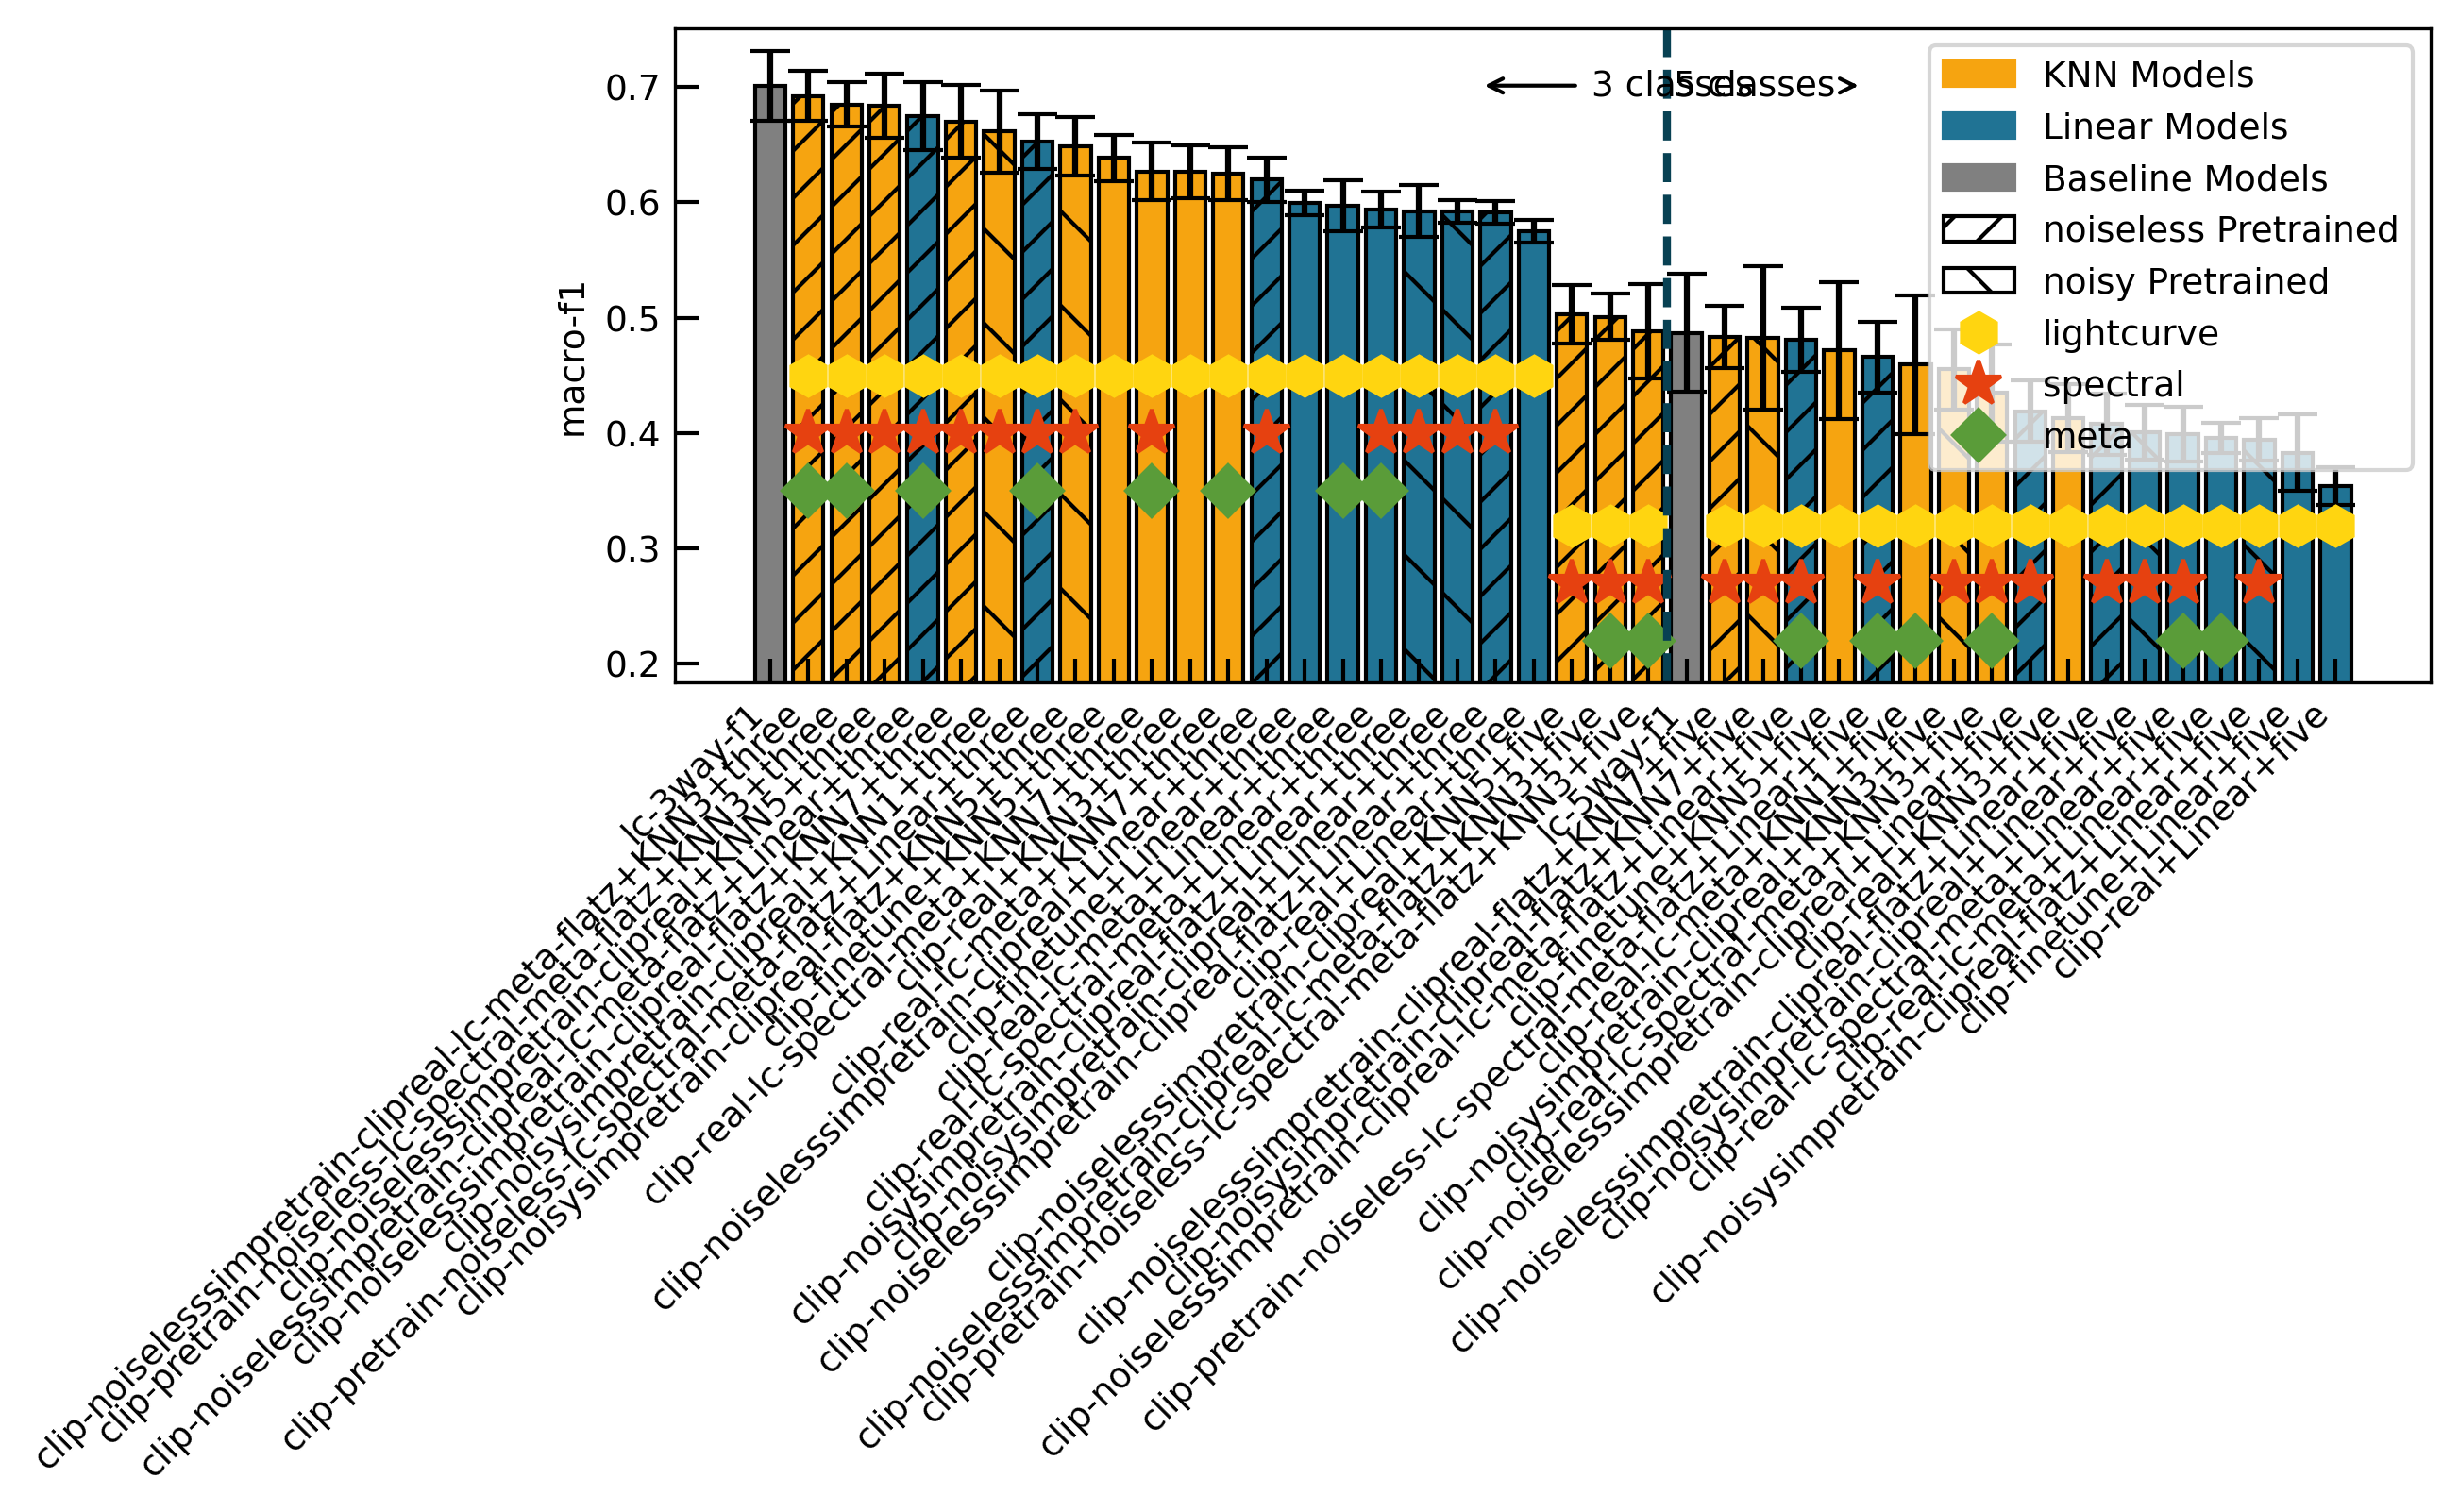

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.rcParams.update(
    {"font.family": "DejaVu Sans", "font.size": 9}  # Adjust the global font size here
)

# Leaderboard in different metrics for classifications
# ========================
variable_name = "mac-f1"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)

lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]

KNNColor = "#f6a410"
LinearColor = "#207394"
LightcurveColor = "#ffd510"
SpectralColor = "#e64110"
MetaColor = "#5a9c39"
divisionLine = "#084153"

colors = [
    KNNColor if "KNN" in model else LinearColor if "Linear" in model else "gray"
    for model in lc_class_mean["Model"]
]
hatches = [
    "//" if "noiseless" in model else "\\" if "noisy" in model else ""
    for model in lc_class_mean["Model"]
]  # hatching for 'nois'

plt.figure(figsize=(8, 3), dpi=300)
bars = plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color=colors,
    hatch=hatches,
    edgecolor="black",
)
maxhight = max(lc_class_mean[variable_name]) + 0.05
minhight = min(lc_class_mean[variable_name]) - 0.17

# Enhance bars for 'meta' models with thicker edges and a top cap
# Place a gold diamond marker in the middle of bars for 'meta' models
for bar, model in zip(bars, lc_class_mean["Model"]):
    if "three" in model or "3way" in model:
        height = 0.4
    else:
        height = 0.27
    if "f1" not in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05,
            "h",
            color=LightcurveColor,
            markersize=10,
        )  # Mid-bar gold diamond
    if "sp" in model or "nois" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            "*",
            color=SpectralColor,
            markersize=12,
        )  # Mid-bar gold diamond
    if "meta" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.05,
            "D",
            color=MetaColor,
            markersize=9,
        )  # Mid-bar gold diamond


# Locate the model just before the maximum 'lc-5way-f1' value
line_position = (
    lc_class_mean["Model"] == "lc-5way-f1"
).argmax() - 0.5  # Set line just before the maximum

# Add a vertical red dotted line before the identified model
plt.axvline(x=line_position, color=divisionLine, linestyle="--", linewidth=2)


# Add annotations with arrows parallel to the x-axis
plt.annotate(
    "3 classes",
    xy=(line_position - 5, maxhight - 0.05),
    xytext=(line_position - 2, maxhight - 0.05),
    arrowprops=dict(arrowstyle="->", color="black"),
    va="center",
)

plt.annotate(
    "5 classes",
    xy=(line_position + 5.0, maxhight - 0.05),
    xytext=(line_position + 0.15, maxhight - 0.05),
    arrowprops=dict(arrowstyle="->", color="black"),
    va="center",
)

# Create legend
red_patch = mpatches.Patch(color=KNNColor, label="KNN Models")
blue_patch = mpatches.Patch(color=LinearColor, label="Linear Models")
gray_patch = mpatches.Patch(color="gray", label="Baseline Models")
noisless_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="//", label="noiseless Pretrained"
)
noisy_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="\\", label="noisy Pretrained"
)
lc_marker = mlines.Line2D(
    [],
    [],
    color=LightcurveColor,
    marker="h",
    linestyle="None",
    markersize=10,
    label="lightcurve",
)
sp_marker = mlines.Line2D(
    [],
    [],
    color=SpectralColor,
    marker="*",
    linestyle="None",
    markersize=12,
    label="spectral",
)
meta_marker = mlines.Line2D(
    [], [], color=MetaColor, marker="D", linestyle="None", markersize=9, label="meta"
)

plt.legend(
    handles=[
        red_patch,
        blue_patch,
        gray_patch,
        noisless_hatch_patch,
        noisy_hatch_patch,
        lc_marker,
        sp_marker,
        meta_marker,
    ]
)

# Set ticks to be inward facing
plt.tick_params(axis="both", which="both", direction="in", length=6, width=1)


plt.ylim([minhight, maxhight])
# plt.xlabel("Model")
plt.ylabel("macro-f1")
# plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
# plt.xticks([])
plt.tight_layout()
plt.savefig("overview-f1.pdf")

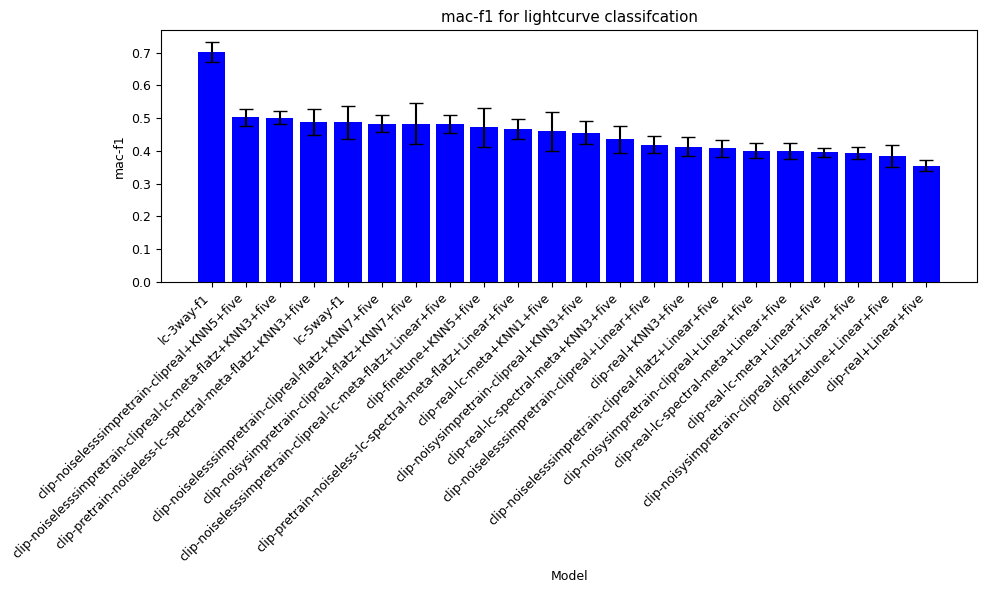

In [44]:
# Leaderboard in different metrics for classifications
# ========================
variable_name = "mac-f1"  # Choose from ['mic-f1', 'mic-p', 'mic-r', 'mic-acc', 'mac-f1', 'mac-p', 'mac-r', 'mac-acc']
modality = "lightcurve"
remove_models = ["three"]
pattern = "|".join(remove_models)

# ========================

lc_class_mean = class_mean[
    class_mean["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == modality
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean[
    ~lc_class_mean["Model"].str.contains(pattern)
].reset_index()
lc_class_std = lc_class_std[~lc_class_std["Model"].str.contains(pattern)].reset_index()


lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]
plt.figure(figsize=(10, 6), dpi=100)
plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color="blue",
)
# plt.ylim([0.7, 0.95])
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.ylim(0.55,0.75)

In [36]:
lc_reg_mean["Model"]

42    clip-pretrain-noiseless-lc-spectral-meta-flatz...
18    clip-noiselesssimpretrain-clipreal-lc-meta-fla...
36    clip-pretrain-noiseless-lc-spectral-meta-flatz...
6               clip-noiselesssimpretrain-clipreal+KNN7
15      clip-noiselesssimpretrain-clipreal-flatz+Linear
27                clip-noisysimpretrain-clipreal+Linear
9             clip-noiselesssimpretrain-clipreal+Linear
21    clip-noiselesssimpretrain-clipreal-lc-meta-fla...
24                  clip-noisysimpretrain-clipreal+KNN7
12        clip-noiselesssimpretrain-clipreal-flatz+KNN7
30            clip-noisysimpretrain-clipreal-flatz+KNN7
33          clip-noisysimpretrain-clipreal-flatz+Linear
3                                  clip-finetune+Linear
72                                               lc-reg
0                                    clip-finetune+KNN7
60                      clip-real-lc-spectral-meta+KNN7
48                                       clip-real+KNN7
54                               clip-real-lc-me

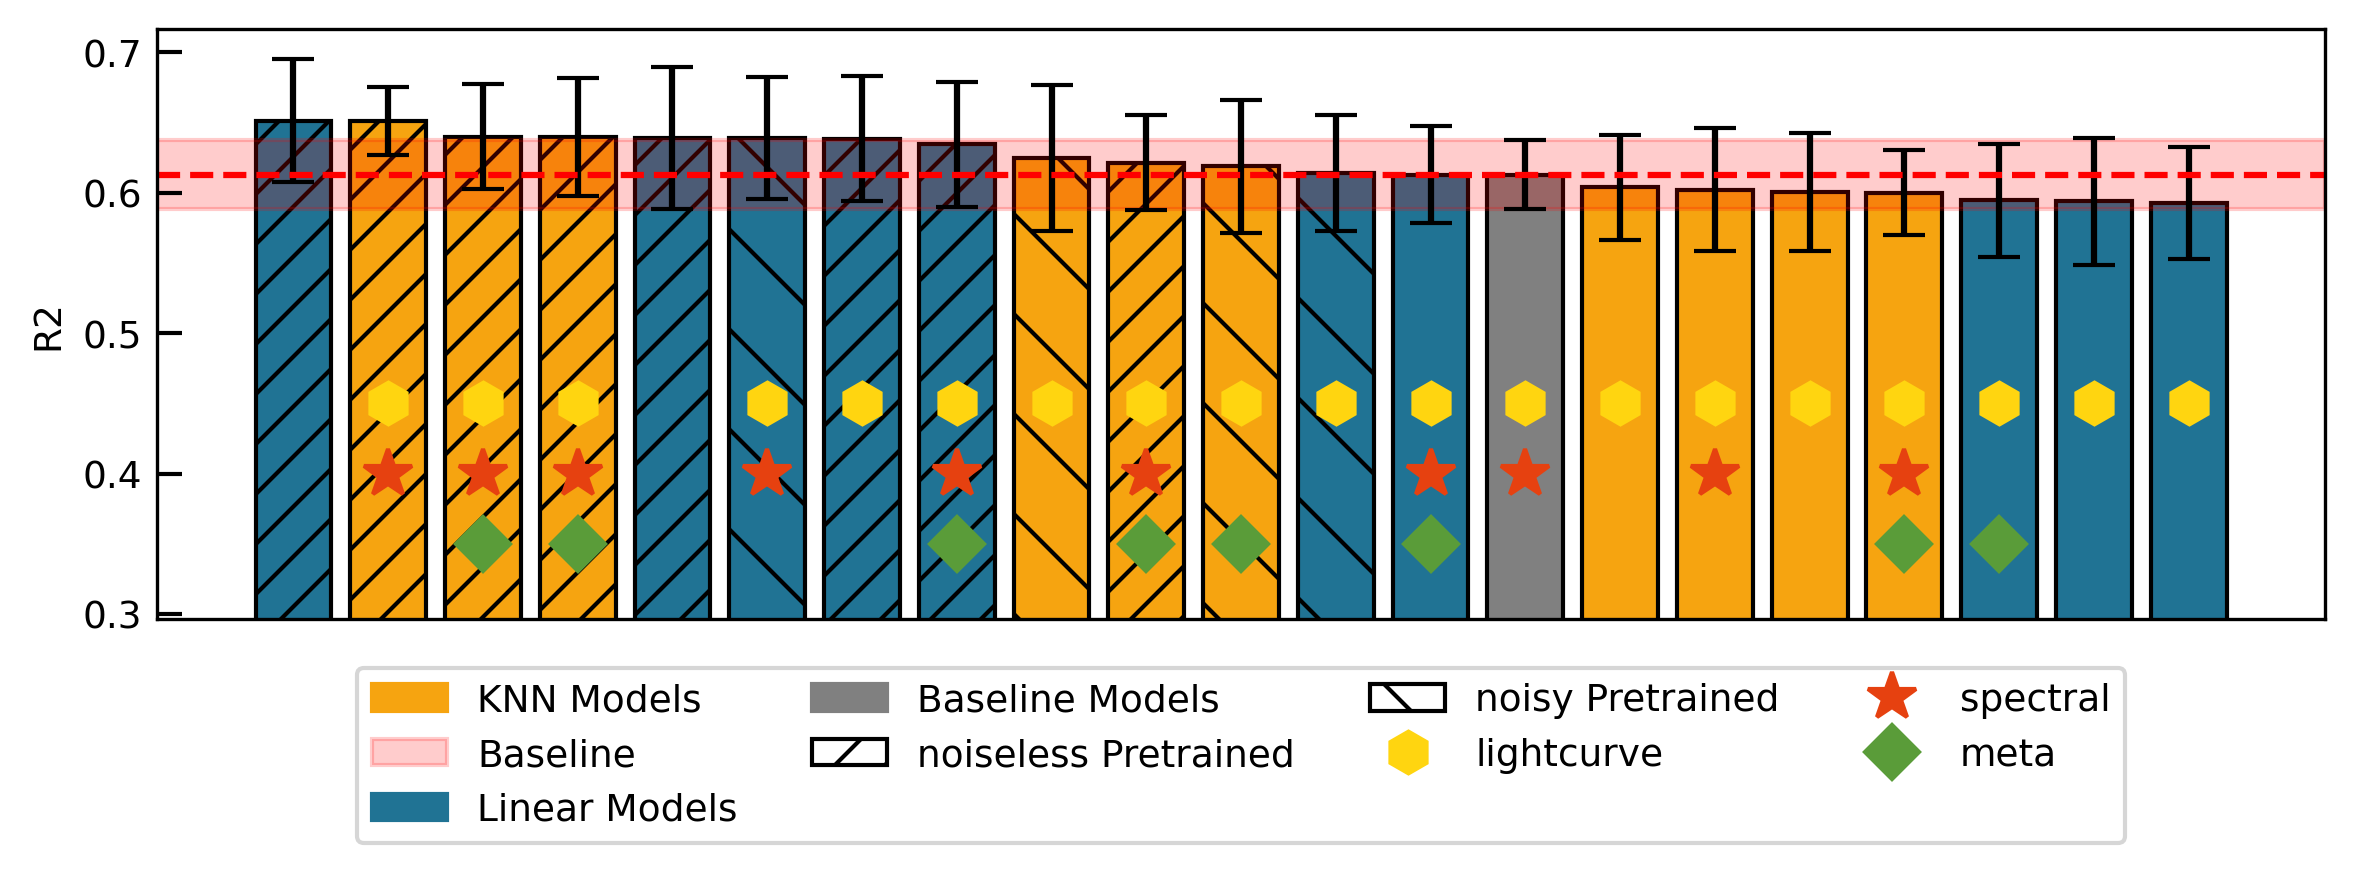

In [45]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.rcParams.update(
    {"font.family": "DejaVu Sans", "font.size": 9}  # Adjust the global font size here
)

# Leaderboard in different metrics for classifications
# ========================
variable_name = "R2"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
# ========================

lc_reg_mean = reg_mean[reg_mean["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]

KNNColor = "#f6a410"
LinearColor = "#207394"
LightcurveColor = "#ffd510"
SpectralColor = "#e64110"
MetaColor = "#5a9c39"
divisionLine = "#084153"

colors = [
    KNNColor if "KNN" in model else LinearColor if "Linear" in model else "gray"
    for model in lc_reg_mean["Model"]
]
hatches = [
    "//" if "noiseless" in model else "\\" if "noisy" in model else ""
    for model in lc_reg_mean["Model"]
]  # hatching for 'nois'

plt.figure(figsize=(8, 3), dpi=300)
bars = plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color=colors,
    hatch=hatches,
    edgecolor="black",
)
maxhight = max(lc_reg_mean[variable_name]) * 1.1
minhight = min(lc_reg_mean[variable_name]) * 0.5

# Enhance bars for 'meta' models with thicker edges and a top cap
# Place a gold diamond marker in the middle of bars for 'meta' models
for bar, model in zip(bars, lc_class_mean["Model"]):
    height = 0.4
    if "f1" not in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05,
            "h",
            color=LightcurveColor,
            markersize=10,
        )  # Mid-bar gold diamond
    if "sp" in model or "noise" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            "*",
            color=SpectralColor,
            markersize=12,
        )  # Mid-bar gold diamond
    if "meta" in model:
        plt.plot(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.05,
            "D",
            color=MetaColor,
            markersize=9,
        )  # Mid-bar gold diamond


# Locate the model just before the maximum 'lc-5way-f1' value
line_position = (
    lc_class_mean["Model"] == "lc-5way-f1"
).argmax() - 0.5  # Set line just before the maximum


# Create legend
red_patch = mpatches.Patch(color=KNNColor, label="KNN Models")
base_patch = mpatches.Patch(color="red", alpha=0.2, label="Baseline")
blue_patch = mpatches.Patch(color=LinearColor, label="Linear Models")
gray_patch = mpatches.Patch(color="gray", label="Baseline Models")
noisless_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="//", label="noiseless Pretrained"
)
noisy_hatch_patch = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="\\", label="noisy Pretrained"
)
lc_marker = mlines.Line2D(
    [],
    [],
    color=LightcurveColor,
    marker="h",
    linestyle="None",
    markersize=10,
    label="lightcurve",
)
sp_marker = mlines.Line2D(
    [],
    [],
    color=SpectralColor,
    marker="*",
    linestyle="None",
    markersize=12,
    label="spectral",
)
meta_marker = mlines.Line2D(
    [], [], color=MetaColor, marker="D", linestyle="None", markersize=9, label="meta"
)

plt.legend(
    handles=[
        red_patch,
        base_patch,
        blue_patch,
        gray_patch,
        noisless_hatch_patch,
        noisy_hatch_patch,
        lc_marker,
        sp_marker,
        meta_marker,
    ],
    ncols=4,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
)


# Set ticks to be inward facing
plt.tick_params(axis="both", which="both", direction="in", length=6, width=1)

ref_val_std = lc_reg_std[variable_name][lc_reg_std["Model"] == "lc-reg"].item()
ref_val = lc_reg_mean[variable_name][lc_reg_mean["Model"] == "lc-reg"].item()
plt.axhline(y=ref_val, color="r", linestyle="--")
plt.axhspan(
    ref_val - ref_val_std,
    ref_val + ref_val_std,
    color="red",
    alpha=0.2,
    label="Region between y=9 and y=11",
)


plt.ylim([minhight, maxhight])
# plt.xlabel("Model")
plt.ylabel(variable_name)
# plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.xticks([])
plt.tight_layout()
plt.savefig(f"overview-{variable_name}.pdf")

(0.5, 0.7)

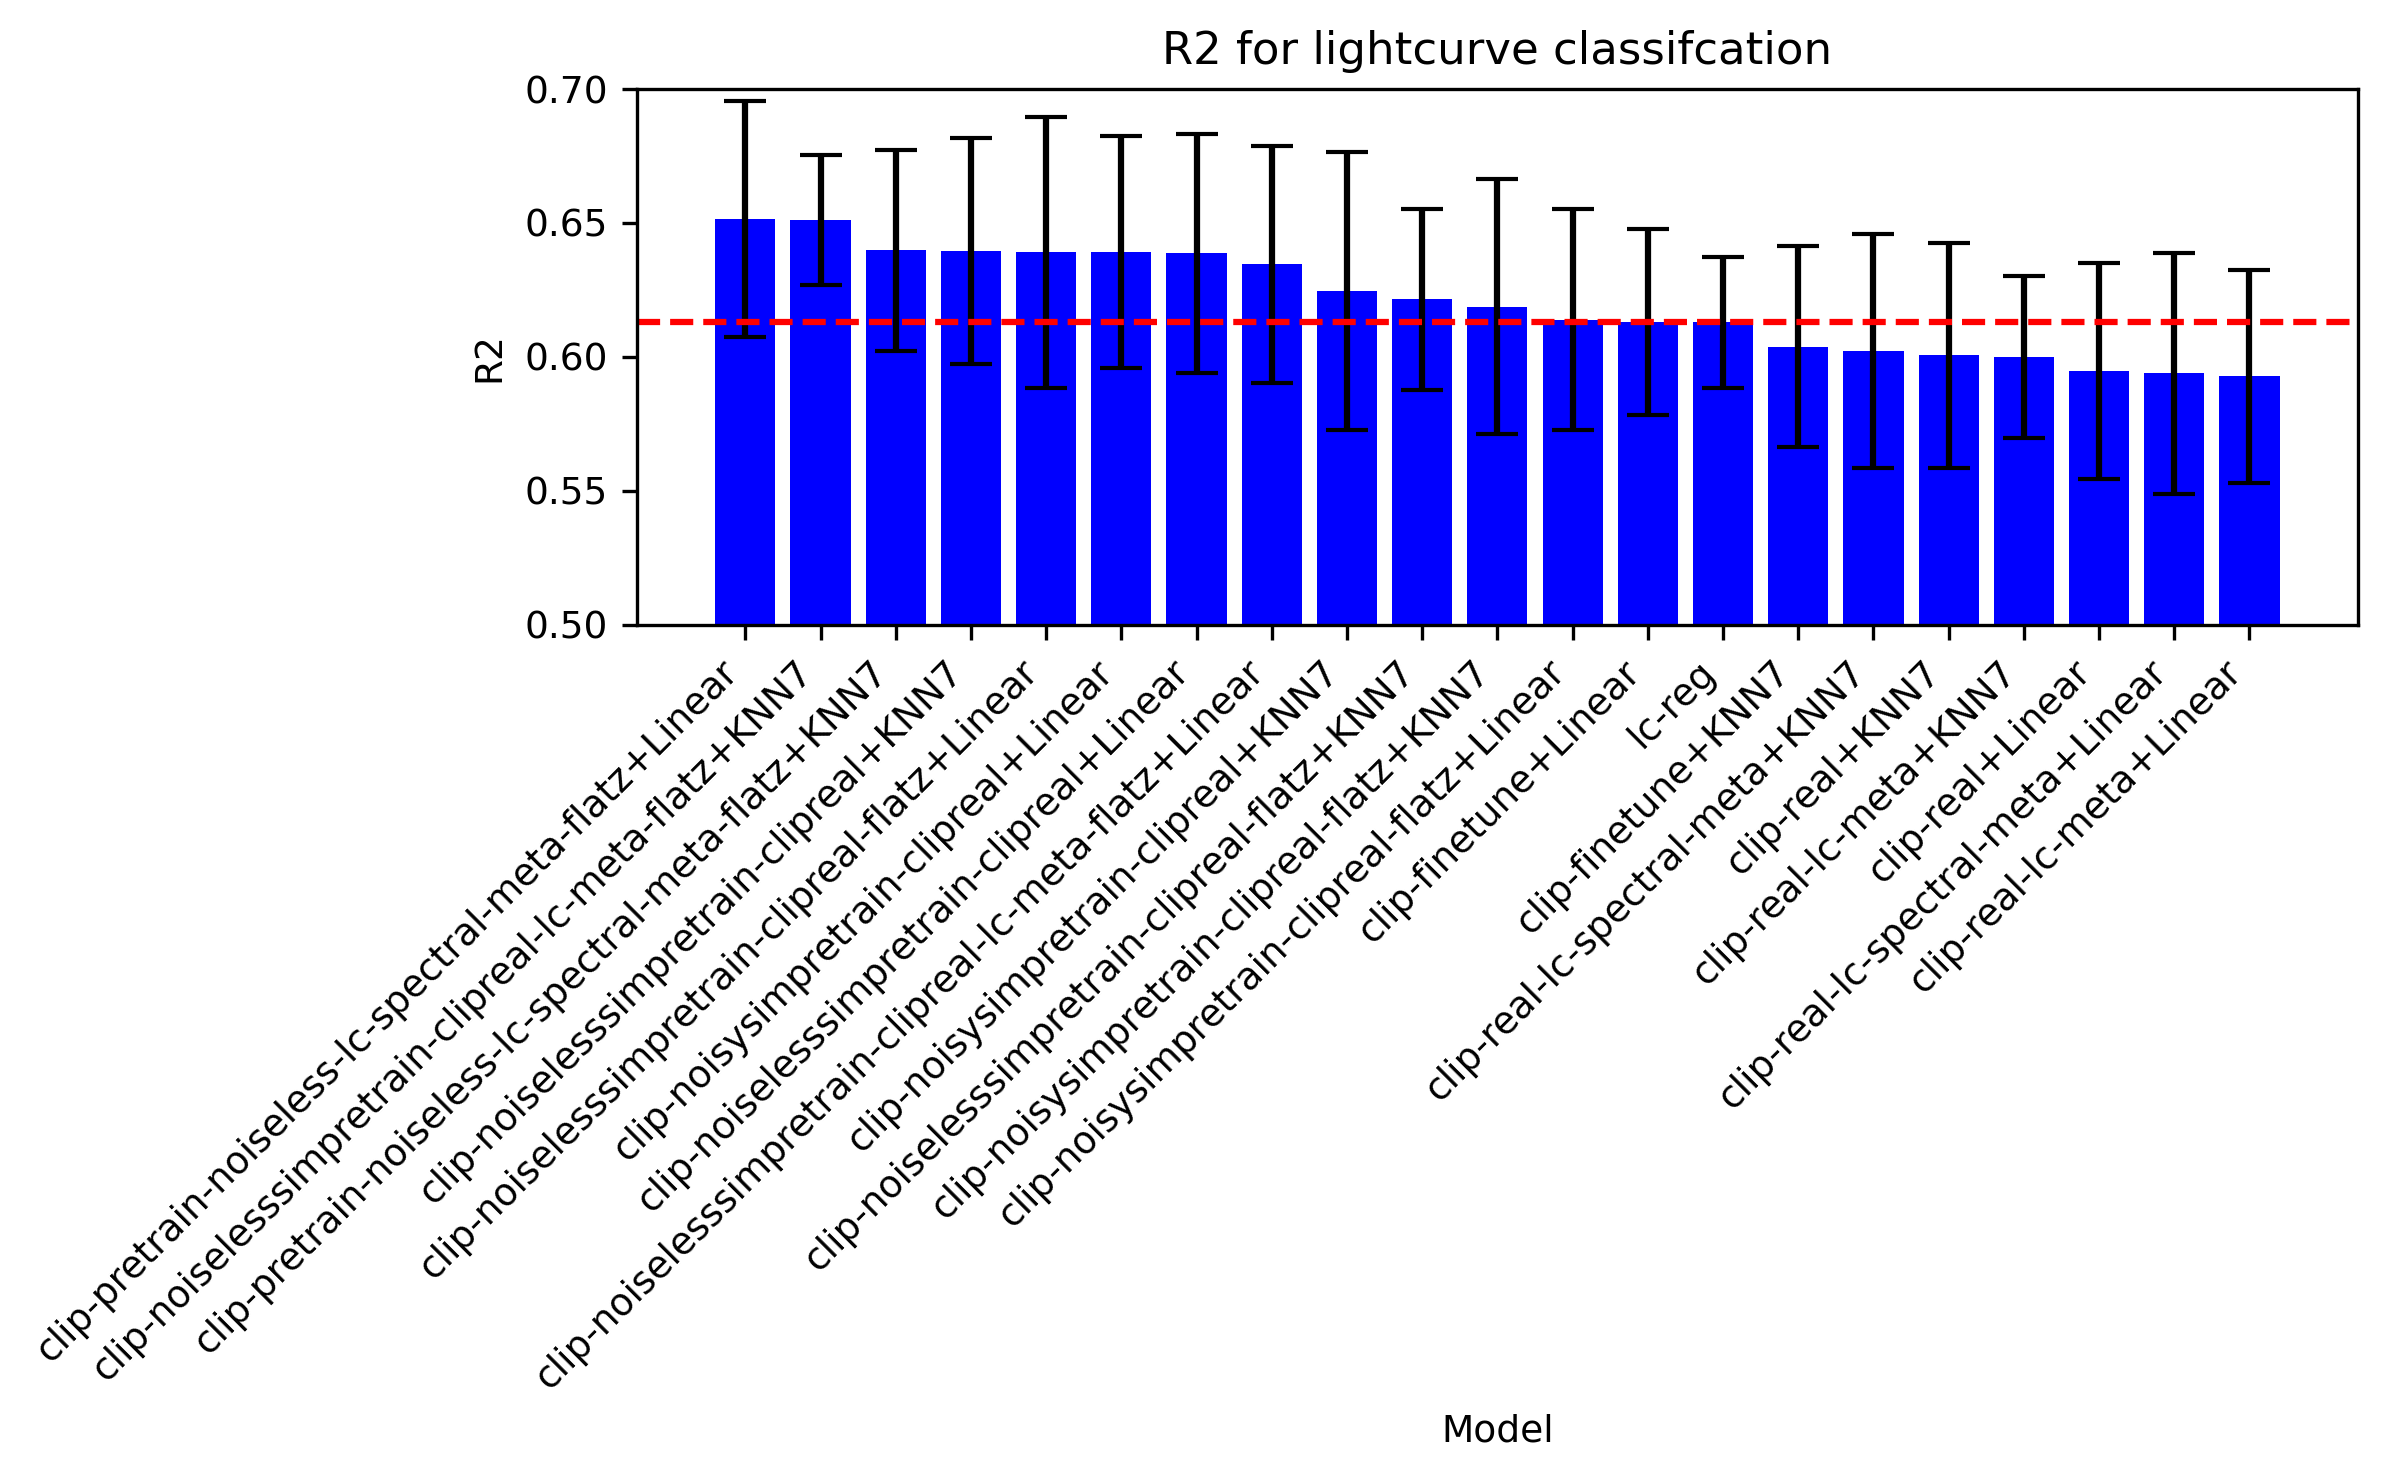

In [14]:
# ========================
variable_name = "R2"  # Choose [ L1	L2	R2	OLF]
modality = "lightcurve"
class_filter = 4.0
remove_models = ["five", "three"]
pattern = "|".join(remove_models)
# Remove rows where the 'Model' column contains any of the strings in remove_models

# ========================

lc_reg_mean = reg_mean[reg_mean["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == modality]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean[~lc_reg_mean["Model"].str.contains(pattern)].reset_index()
lc_reg_std = lc_reg_std[~lc_reg_std["Model"].str.contains(pattern)].reset_index()

lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color="blue",
)
ref_val = lc_reg_mean[variable_name][lc_reg_mean["Model"] == "lc-reg"].item()
plt.axhline(y=ref_val, color="r", linestyle="--", label="y=10")

plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.ylim(0.5, 0.7)

### Classification results analysis - Analysis of redshift of rightly classified SN

In [15]:
def filter_elements(df, target_class):
    """
    Filters the DataFrame to include only rows where the specified target class is present.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing model predictions and true labels.
    target_class (float): The target class to filter for.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered cases for the specified target class.
    """
    # Ensure the original 'y_pred' is kept intact for reference
    df["y_pred_all"] = df["y_true"]

    # Function to apply the mask within the arrays
    def filter_arrays(row):
        indices_pos_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred == target_class and true_label == target_class
        ]
        indices_all = [
            i
            for i, true_label in enumerate(row["y_true_label"])
            if true_label == target_class
        ]
        indices_neg_class = [
            i
            for i, (pred, true_label) in enumerate(
                zip(row["y_pred"], row["y_true_label"])
            )
            if pred != target_class and true_label == target_class
        ]
        filtered_lc_data_all = (
            {
                key: [row["lc_data"][key][i] for i in indices_all]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_pos = (
            {
                key: [row["lc_data"][key][i] for i in indices_pos_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )
        filtered_lc_data_neg = (
            {
                key: [row["lc_data"][key][i] for i in indices_neg_class]
                for key in row["lc_data"]
            }
            if "lc_data" in row
            else None
        )

        return {
            "y_pred": [row["y_pred"][i] for i in indices_pos_class],
            "y_true": [row["y_true"][i] for i in indices_pos_class],
            "y_true_label": [row["y_true_label"][i] for i in indices_pos_class],
            "y_pred_all": [row["y_pred_all"][i] for i in indices_all],
            "lc_data_all": filtered_lc_data_all,
            "lc_data": filtered_lc_data_pos,
            "lc_data_not": filtered_lc_data_neg,
        }

    # Apply the function to each row in the DataFrame
    filtered_data = df.apply(filter_arrays, axis=1)

    # Create a new DataFrame from the filtered data
    result_df = pd.DataFrame(filtered_data.tolist(), index=df.index)

    # Handle the lc_data separately to avoid column overlap
    lc_data_filtered = result_df.pop("lc_data")

    # Combine the filtered arrays back with the original DataFrame
    final_df = df.drop(columns=["y_pred", "y_true", "y_true_label", "y_pred_all"]).join(
        result_df
    )

    # Add the lc_data back to the final DataFrame
    final_df["lc_data"] = lc_data_filtered

    return final_df.reset_index(drop=True)

Filter out the models you want to compare the redshift distribtion

In [16]:
class_filter = 4.0
remove_models = ["three", "3way", "Linear", "noisy", "5way", "clip-real"]
"""
remove_models = [
    "three",
    "3way",
    "Linear",
]  
"""
lc_merged_classification = merged_classification[
    merged_classification["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_classification[
    ~lc_merged_classification["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])
print(f"and we will remove class {class_names[int(class_filter)][0]}")

We will work with these models: 
                                                Model Combination
0                             clip-finetune+KNN1+five  lightcurve
1                             clip-finetune+KNN2+five  lightcurve
2                             clip-finetune+KNN3+five  lightcurve
3                             clip-finetune+KNN5+five  lightcurve
4                             clip-finetune+KNN7+five  lightcurve
5        clip-noiselesssimpretrain-clipreal+KNN1+five  lightcurve
6        clip-noiselesssimpretrain-clipreal+KNN2+five  lightcurve
7        clip-noiselesssimpretrain-clipreal+KNN3+five  lightcurve
8        clip-noiselesssimpretrain-clipreal+KNN5+five  lightcurve
9        clip-noiselesssimpretrain-clipreal+KNN7+five  lightcurve
10  clip-noiselesssimpretrain-clipreal-flatz+KNN1+...  lightcurve
11  clip-noiselesssimpretrain-clipreal-flatz+KNN2+...  lightcurve
12  clip-noiselesssimpretrain-clipreal-flatz+KNN3+...  lightcurve
13  clip-noiselesssimpretrain-clipreal-flat

<Figure size 1000x600 with 0 Axes>

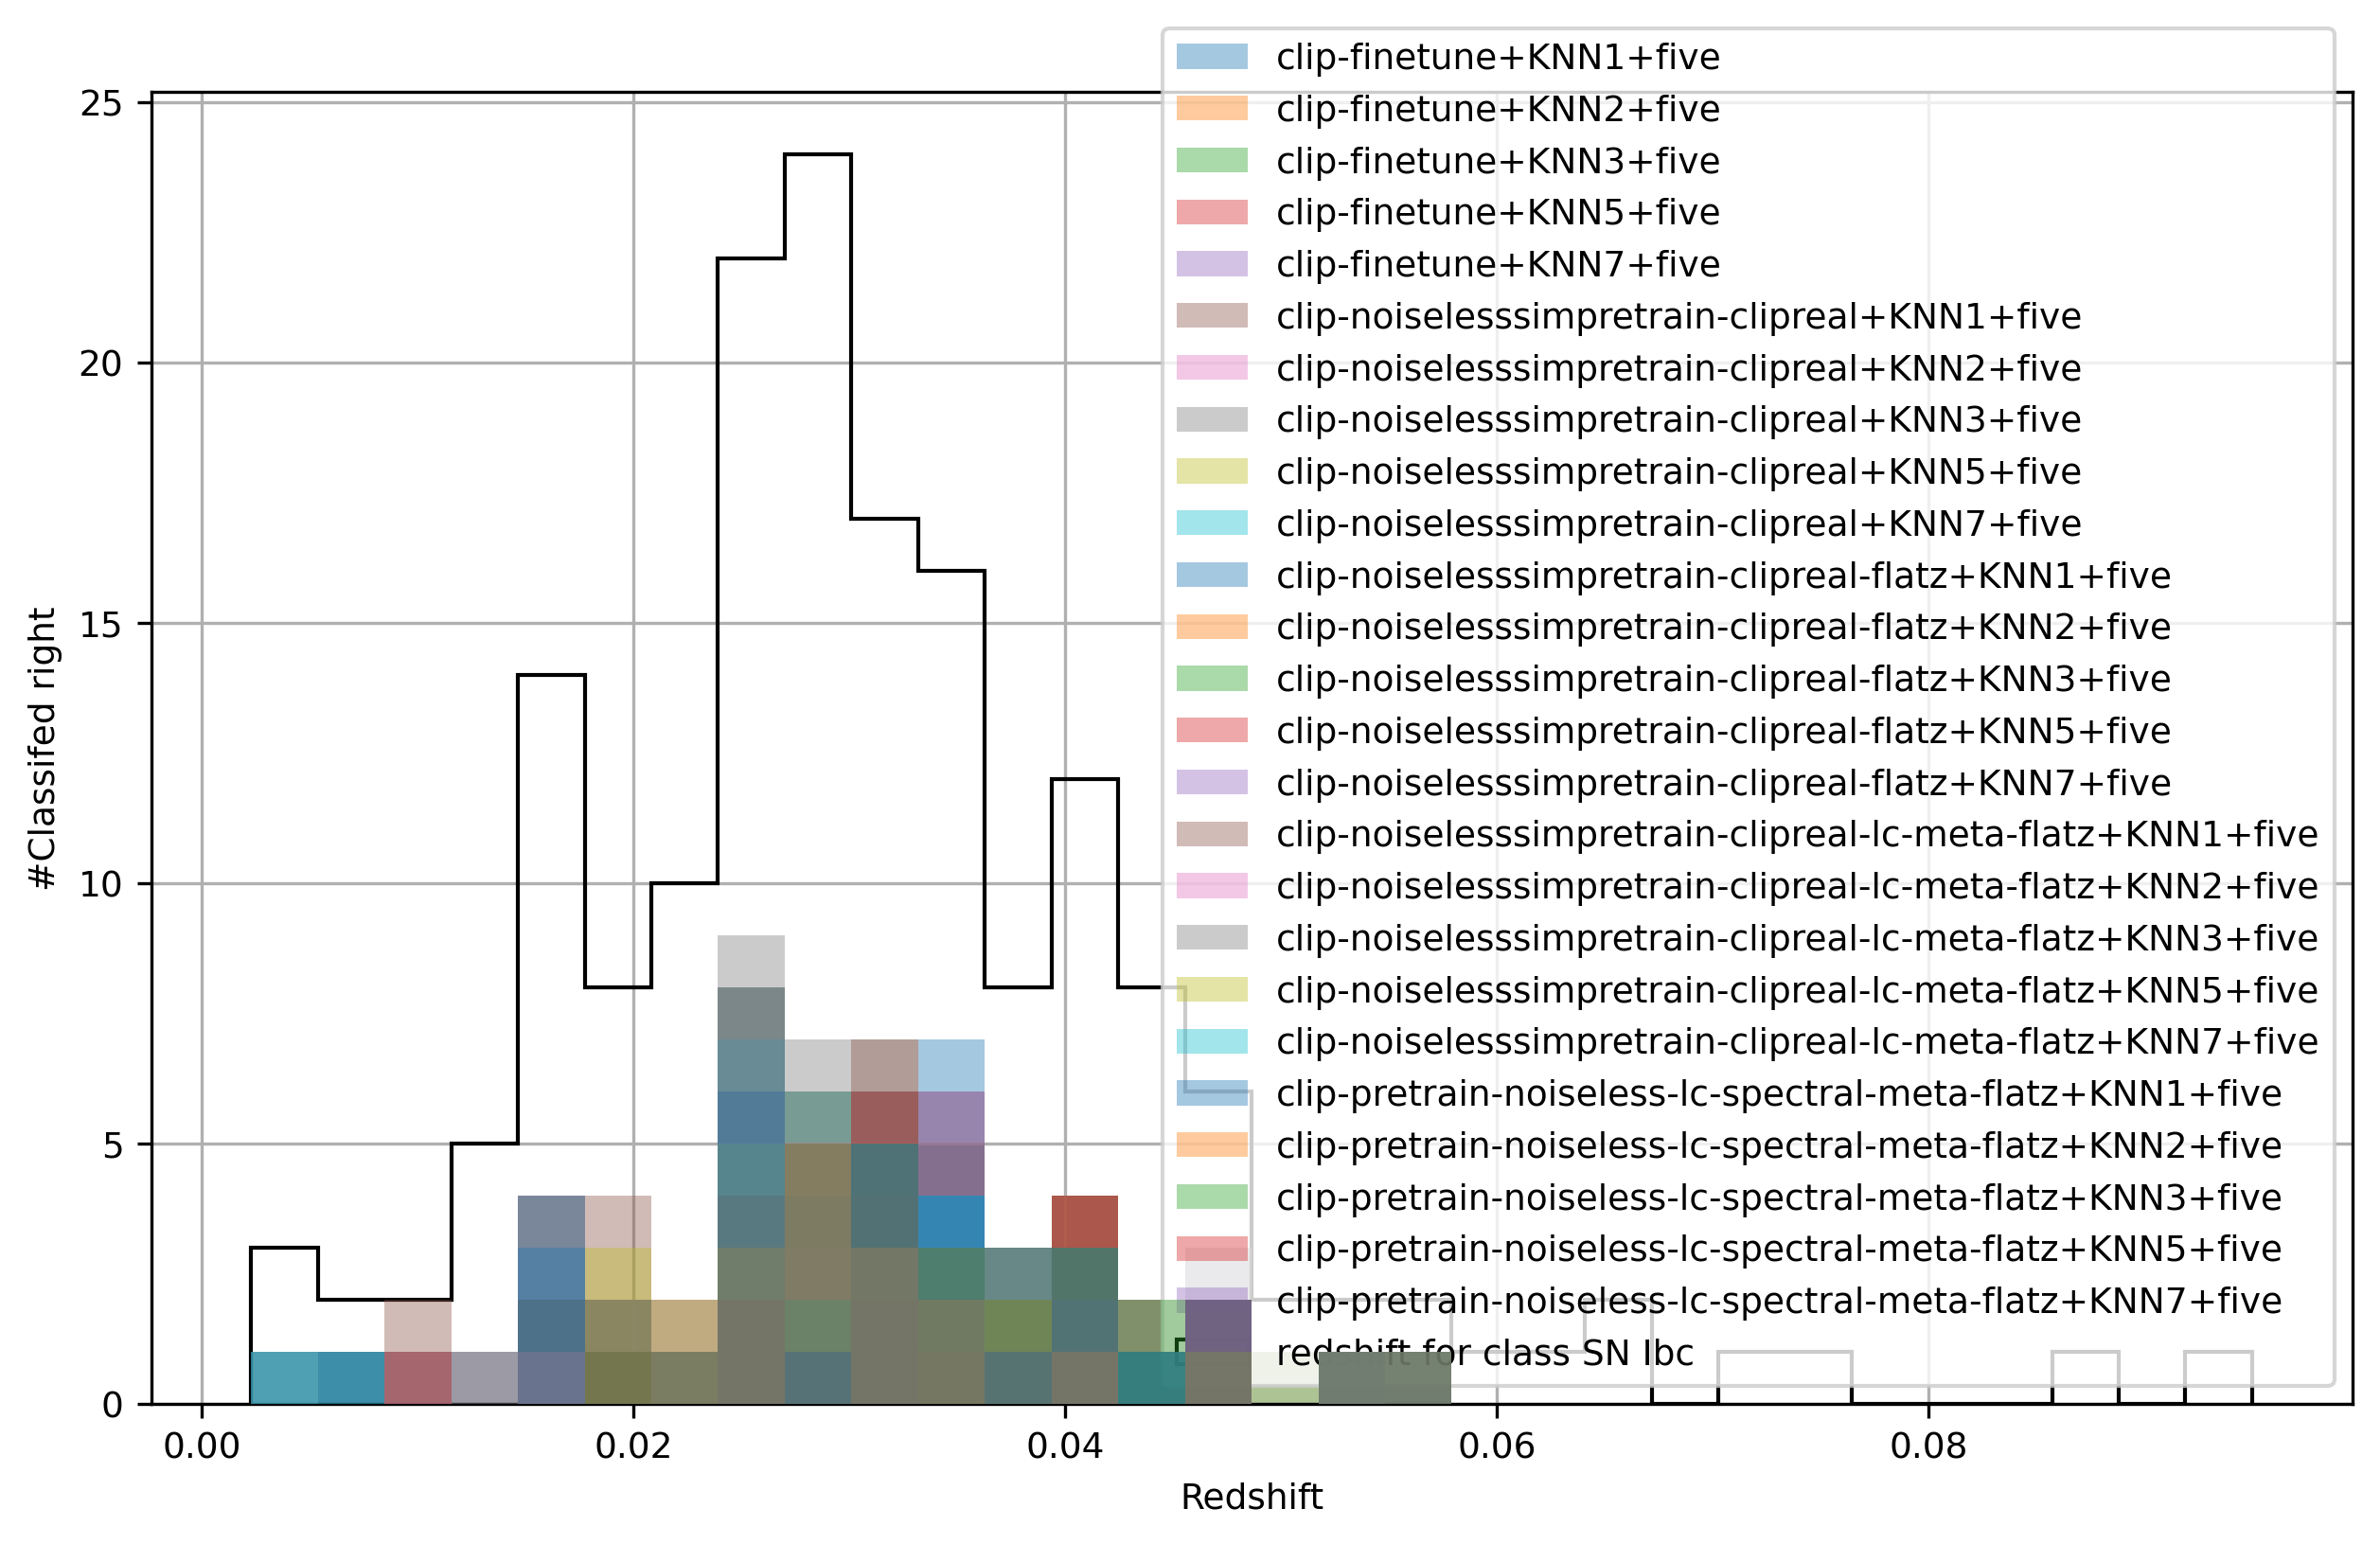

In [17]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)

plt.figure(figsize=(10, 6))

# Determine the number of subplots needed
fig = plt.figure(figsize=(10, 6), dpi=300)
total_class_hist = filtered_classified["y_pred_all"][0]

for i, (index, row) in enumerate(filtered_classified.iterrows()):
    plt.hist(
        row["y_true"],
        bins=30,
        label=row["Model"],
        range=[min(total_class_hist), max(total_class_hist)],
        alpha=0.4,
        zorder=20 - i,
    )
plt.hist(
    total_class_hist,
    color="black",
    edgecolor="black",
    bins=30,
    range=[min(total_class_hist), max(total_class_hist)],
    label=f"redshift for class {class_names[int(class_filter)][0]}",
    histtype="step",
)
plt.xlabel("Redshift")
plt.ylabel("#Classifed right")
plt.legend()
plt.grid(True)

plt.savefig("redshiftmissclass.pdf")
plt.show()

In [18]:
def compute_masked_min(filtered_df, data="lc_data"):
    """
    Computes the minimum of x_lc after applying mask_lc for each batch.

    Parameters:
    filtered_df (pd.DataFrame): The filtered DataFrame containing 'lc_data' with 'x_lc' and 'mask_lc'.

    Returns:
    List: A list containing the masked minimum values for each batch.
    """
    x_lc_list = filtered_df[data].apply(lambda d: d["x_lc"] if d is not None else None)
    mask_lc_list = filtered_df[data].apply(
        lambda d: d["mask_lc"] if d is not None else None
    )
    masked_min_list = []

    for x_lc, mask_lc in zip(x_lc_list, mask_lc_list):
        if x_lc is not None and len(x_lc) > 0:
            masked_min = np.min(np.where(mask_lc, x_lc, np.inf), axis=1)
            masked_min_list.append(masked_min)
        else:
            masked_min_list.append([])

    return masked_min_list

In [19]:
# Filter out classes
filtered_classified = filter_elements(df_cleaned, class_filter)
min_lc_data_hit = compute_masked_min(filtered_classified, "lc_data")
min_lc_data_class_all = compute_masked_min(filtered_classified, "lc_data_all")
min_lc_data_miss = compute_masked_min(filtered_classified, "lc_data_not")

In [20]:
filtered_classified["Model"]

0                               clip-finetune+KNN1+five
1                               clip-finetune+KNN2+five
2                               clip-finetune+KNN3+five
3                               clip-finetune+KNN5+five
4                               clip-finetune+KNN7+five
5          clip-noiselesssimpretrain-clipreal+KNN1+five
6          clip-noiselesssimpretrain-clipreal+KNN2+five
7          clip-noiselesssimpretrain-clipreal+KNN3+five
8          clip-noiselesssimpretrain-clipreal+KNN5+five
9          clip-noiselesssimpretrain-clipreal+KNN7+five
10    clip-noiselesssimpretrain-clipreal-flatz+KNN1+...
11    clip-noiselesssimpretrain-clipreal-flatz+KNN2+...
12    clip-noiselesssimpretrain-clipreal-flatz+KNN3+...
13    clip-noiselesssimpretrain-clipreal-flatz+KNN5+...
14    clip-noiselesssimpretrain-clipreal-flatz+KNN7+...
15    clip-noiselesssimpretrain-clipreal-lc-meta-fla...
16    clip-noiselesssimpretrain-clipreal-lc-meta-fla...
17    clip-noiselesssimpretrain-clipreal-lc-meta

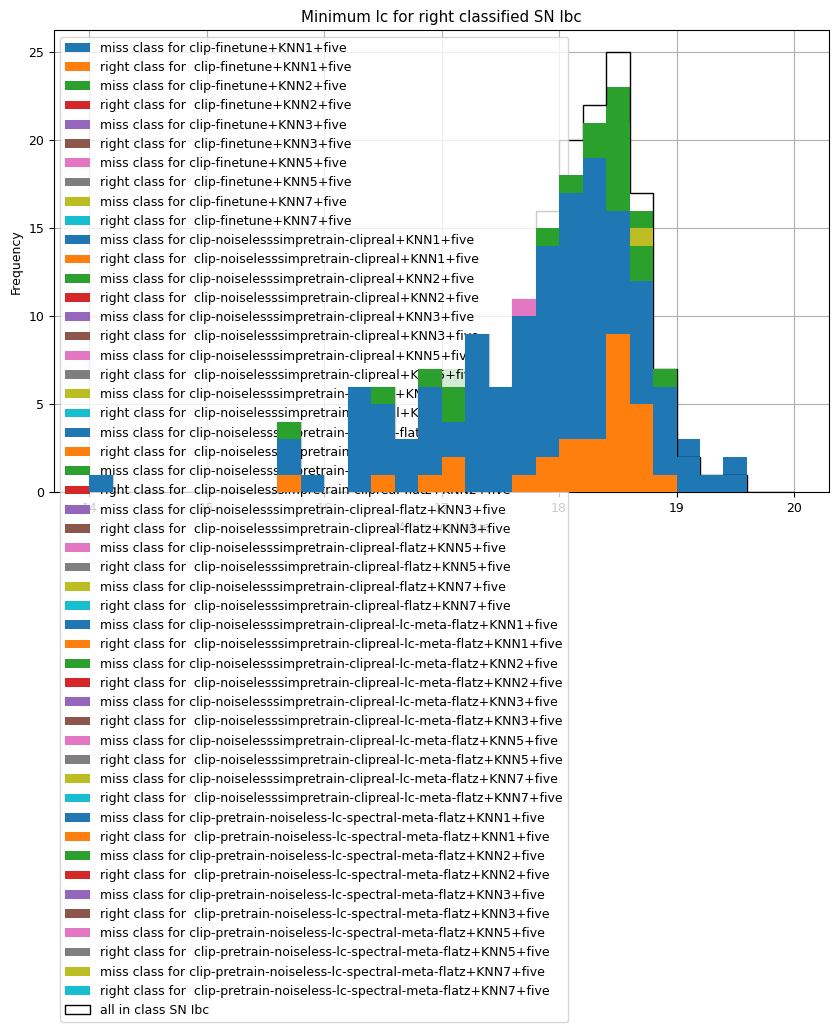

In [21]:
# Plot the masked minimum values
plt.figure(figsize=(10, 6))
for i, (hit, miss) in enumerate(zip(min_lc_data_hit, min_lc_data_miss)):
    if hit is not None:
        plt.hist(
            miss,
            bins=30,
            alpha=1,
            label=f'miss class for {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )
        plt.hist(
            hit,
            bins=30,
            alpha=1,
            label=f'right class for  {filtered_classified["Model"][i]}',
            range=(14, 20),
            zorder=10 - i,
        )

plt.hist(
    min_lc_data_class_all[0],
    bins=30,
    label=f"all in class {class_names[int(class_filter)][0]}",
    range=(14, 20),
    histtype="step",
    edgecolor="black",
)

plt.title(f"Minimum lc for right classified {class_names[int(class_filter)][0]}")
plt.xlabel("Minimum Value")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Plot confusion plots

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


def plot_cm(df_class, modelname, modality, normalisation):
    df_class_filter = df_class[df_class["Model"] == modelname].reset_index()
    df_class_filter = df_class_filter[
        df_class_filter["Combination"] == modality
    ].reset_index()

    if "five" in modelname or "5way" in modelname:
        class_names = {
            0: ("SLSN-I", "blue"),
            1: ("SN II", "green"),
            2: ("SN IIn", "teal"),
            3: ("SN Ia", "purple"),
            4: ("SN Ibc", "orange"),
        }
    else:
        class_names = {
            0: ("SN II", "green"),
            1: ("SN Ia", "purple"),
            2: ("SN Ibc", "orange"),
        }

    cm = confusion_matrix(
        df_class_filter["y_true_label"][0], df_class_filter["y_pred"][0]
    )
    if normalisation == "recall":
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        formats = ".2f"
    elif normalisation == "precision":
        cm = cm.astype("float") / cm.sum(axis=0, keepdims=True)
        formats = ".2f"
    else:
        formats = "d"

    # Create the plot
    plt.figure(figsize=(5, 4), dpi=100)
    sns.heatmap(
        cm,
        annot=True,
        fmt=formats,
        cmap="Blues",
        xticklabels=[class_names[label][0] for label in sorted(class_names)],
        yticklabels=[class_names[label][0] for label in sorted(class_names)],
    )
    plt.title(
        f'Normalized Confusion Matrix: {df_class_filter["Model"][0]}, {df_class_filter["Combination"][0]}'
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [23]:
print(f'available models: \n {merged_classification["Model"]}')

available models: 
 0                      clip-finetune+KNN1+five
1                      clip-finetune+KNN1+five
2                      clip-finetune+KNN1+five
3                     clip-finetune+KNN1+three
4                     clip-finetune+KNN1+three
                        ...                   
431    clip-real-lc-spectral-meta+Linear+three
432                                 lc-3way-f1
433                                 lc-5way-f1
434                                 sp-3way-f1
435                                 sp-5way-f1
Name: Model, Length: 436, dtype: object


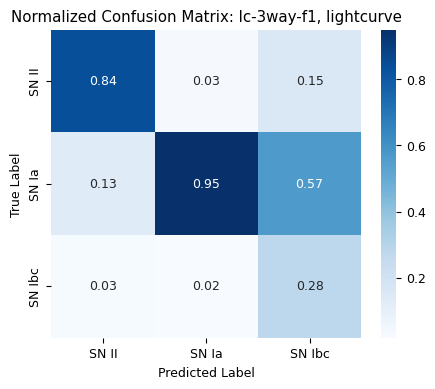

In [24]:
plot_cm(
    merged_classification,
    modelname="lc-3way-f1",
    modality="lightcurve",
    normalisation="precision",  # "recall" / "precision"
)

In [25]:
plot_cm(
    merged_classification,
    modelname="clip-noiselesssimpretrain-clipreal+KNN+three",
    modality="lightcurve",
    normalisation="precision",  # "recall" / "precision"
)

KeyError: 0

# Classbased analysis of regression results

In [ ]:
def get_class_regression_metric(df):
    df = pd.DataFrame(df)
    class_dependent_regression_metrics = []
    # Iterate over each row in the DataFrame to create plots
    for index, row in df.iterrows():
        y_pred = torch.Tensor(row["y_pred"])
        y_true = torch.Tensor(row["y_true"])
        y_true_label = torch.Tensor(row["y_true_label"])
        label = row["Model"]
        combs = row["Combination"]
        id = row["id"]
        task = "regression"

        # Determine global axis limits
        x_min, x_max = y_true.min(), y_true.max()
        y_min, y_max = y_pred.min(), y_pred.max()

        x_min = min(0, x_min)
        y_min = min(0, y_min)

        # Setup for subplots
        unique_labels = np.unique(y_true_label)
        for i, classid in enumerate(unique_labels, 1):

            # Highlight the current class
            idx = y_true_label == classid

            metrics, results = calculate_metrics(
                y_true[idx],
                y_true_label[idx],
                y_pred[idx],
                None,
                label + "+" + class_names[classid][0],
                combs,
                id=id,
                task=task,
            )
            class_dependent_regression_metrics.append(metrics)
    return class_dependent_regression_metrics


class_dependent_regression_metrics = get_class_regression_metric(
    collect_regression_results
)
class_dependent_regression_metrics_all = get_class_regression_metric(merged_regression)

In [ ]:
regress_class_dependet_mean, regress_class_dependet_std = calculate_kfold_mean_and_std(
    class_dependent_regression_metrics
)

In [ ]:
supernovae_type = "SN IIn"  # ['SLSN-I', 'SN II', 'SN IIn', 'SN Ia', 'SN Ibc']
modality = "lightcurve"
variable_name = "R2"

mean_data_filtered = regress_class_dependet_mean[
    regress_class_dependet_mean["Combination"] == modality
].reset_index()
std_data_filtered = regress_class_dependet_std[
    regress_class_dependet_std["Combination"] == modality
].reset_index()

std_data_filtered["supernova_type"] = [
    entry.split("+")[-1] for entry in std_data_filtered["Model"]
]
mean_data_filtered["supernova_type"] = [
    entry.split("+")[-1] for entry in mean_data_filtered["Model"]
]
# Extract data for lightcurve combination

mean_data_filteredSNtype = mean_data_filtered[
    mean_data_filtered["supernova_type"] == supernovae_type
].reset_index()
std_data_filteredSNtype = std_data_filtered[
    std_data_filtered["supernova_type"] == supernovae_type
].reset_index()

mean_data_filteredSNtype = mean_data_filteredSNtype.sort_values(
    by=variable_name, ascending=False
)
std_data_filteredSNtype = std_data_filteredSNtype.loc[mean_data_filteredSNtype.index]

plt.figure(figsize=(8, 5), dpi=300)
plt.bar(
    mean_data_filteredSNtype["Model"],
    mean_data_filteredSNtype[variable_name],
    yerr=std_data_filteredSNtype[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve for {supernovae_type} events")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [ ]:
import os


def plot_all_pred_vs_true(df, class_names):
    """
    Creates and saves a plot for each row in the DataFrame, where each subplot within a plot
    corresponds to a unique class. Each class is plotted with its designated color and label.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the data for plots. Expected to have columns:
      'y_pred', 'y_true', 'y_true_label', 'Model', and 'Combination'.
    - folder_name (str): Directory name where the plots will be saved.
    - class_names (dict): Dictionary mapping class labels (int) to tuples of (class name, color).

    Each plot is saved with the filename format "Model_Combination.png", where spaces are removed.
    """

    # Iterate over each row in the DataFrame to create plots
    plt.figure(figsize=(15, 30))
    ymins = []
    ymaxs = []
    xmins = []
    xmaxs = []

    for index, row in df.iterrows():
        y_pred = np.array(row["y_pred"])
        y_true = np.array(row["y_true"])
        y_true_label = np.array(row["y_true_label"])
        model = row["Model"]

        # Determine global axis limits
        x_min, x_max = y_true.min(), y_true.max()
        y_min, y_max = y_pred.min(), y_pred.max()

        x_min = min(0, x_min)
        y_min = min(0, y_min)
        ymins.append(y_min)
        ymaxs.append(y_max)
        xmins.append(x_min)
        xmaxs.append(x_max)

        # Setup for subplots
        unique_labels = np.unique(y_true_label)
        n_classes = len(class_names)
        red_line = np.linspace(-1, 1, 100)
        for i, label in enumerate(range(n_classes), 1):
            ax = plt.subplot(n_classes, 1, i)

            # Highlight the current class
            idx = y_true_label == label
            class_color = class_names[label][1]  # Color corresponding to the label
            if model != "lc-reg":
                ax.scatter(
                    y_true[idx],
                    y_pred[idx],
                    # color=class_color,
                    label=f"{model}",
                )
            else:
                ax.scatter(
                    y_true[idx],
                    y_pred[idx],
                    # color=class_color,
                    label=f"{model}",
                    alpha=0.5,
                    c="gray",
                )

            ax.plot(
                red_line, red_line, linewidth=3, alpha=0.4, linestyle="--", color="red"
            )

            # Set tick parameters
            ax.xaxis.set_major_locator(
                ticker.MultipleLocator(0.05)
            )  # Adjust tick spacing as needed
            ax.yaxis.set_major_locator(
                ticker.MultipleLocator(0.05)
            )  # Adjust tick spacing as needed
            ax.tick_params(direction="in", length=6, width=2)

            ax.set_title(f"{class_names[label][0]}")
            ax.set_xlabel("True Redshift")
            ax.set_ylabel("Predicted Redshift")
            ax.set_xlim(min(xmins), max(xmaxs))
            ax.set_ylim(min(ymins), max(ymaxs))
            ax.legend()
            ax.grid(True)

In [ ]:
remove_models = ["five", "5way", "Linear", "nois", "clip-real", "spectral"]
"""
remove_models = [
    "three",
    "3way",
    "Linear",
]  
"""
merged_regression = pd.DataFrame(merged_regression)
lc_merged_regression = merged_regression[
    merged_regression["Combination"] == "lightcurve"
]

# Create a regex pattern from the list of strings
pattern = "|".join(remove_models)

if "three" in remove_models:
    class_names = {
        0: ("SLSN-I", "blue"),
        1: ("SN II", "green"),
        2: ("SN IIn", "teal"),
        3: ("SN Ia", "purple"),
        4: ("SN Ibc", "orange"),
    }
else:
    class_names = {
        0: ("SN II", "green"),
        1: ("SN Ia", "purple"),
        2: ("SN Ibc", "orange"),
    }

# Remove rows where the 'Model' column contains any of the strings in remove_models
df_cleaned = lc_merged_regression[
    ~lc_merged_regression["Model"].str.contains(pattern)
].reset_index()
print("We will work with these models: ")
print(df_cleaned[["Model", "Combination"]])

In [ ]:
plot_all_pred_vs_true(df_cleaned, class_names)
plt.savefig("meh.png")

In [ ]:
!python finetune_clip.py configs/clip_finetune_meta.yaml